# Домашнее задание 3. Бонус. Object detection.

Вы можете получить за это задание до 5 баллов.





В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
# we will need this library to process the labeling
!pip install xmltodict
!pip install --upgrade albumentations

     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 952kB 20.9MB/s 
     |████████████████████████████████| 36.7MB 85kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import glob
import cv2
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

import albumentations.pytorch.transforms
import albumentations as A
import xmltodict
import json

Датасет мы за вас написали. (*Спасибо!*)


In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    # и правда выпишем код с семинара
    dt = dt_bbox
    gt = gt_bbox
    maxX = max(dt[0], gt[0])
    minX = min(dt[2], gt[2])
    maxY = max(dt[1], gt[1])
    minY = min(dt[3], gt[3])
    if minX < maxX or minY < maxY:
        return 0
    else:
        inter = (minX - maxX) * (minY - maxY)
    union = (dt[2] - dt[0]) * (dt[3] - dt[1]) + (gt[2] - gt[0]) * (gt[3] - gt[1]) - inter

    return float(inter) / union

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if (len(results) == 0):
        return 0.0

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.94__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * (Ваш auc - 0.5) / 0.94)__.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def get_detection_model(num_classes=3):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model = model.to(device).train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        print("epoch {}/{}..".format(epoch, n_epochs))
        start = time.time()
        train_one_epoch(model, optimizer, train_dataloader, device)
        a = evaluate(model, val_dataloader, device=device)
        end = time.time()
        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("AUC ON TEST: {:.4f}".format(a))

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
train_transform = A.Compose([A.RandomBrightnessContrast(p = 0.2),
                             A.RandomRotate90(),
                             A.RandomContrast(),
                             albumentations.pytorch.transforms.ToTensor()
             ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['labels']))

val_transform = A.Compose([A.RandomBrightnessContrast(p = 0.2),
                           albumentations.pytorch.transforms.ToTensor()
             ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['labels']))

train_dataset = FruitDataset("drive/MyDrive/archive/train_zip/train", transform=train_transform)
val_dataset = FruitDataset("drive/MyDrive/archive/test_zip/test", transform=val_transform)

In [6]:
num_classes = 4
model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

n_epochs = 3

train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

epoch 0/3..
Loss value after 10 batches is 0.64
Loss value after 20 batches is 0.5
Loss value after 30 batches is 0.41
Loss value after 40 batches is 0.35
Loss value after 50 batches is 0.31
Loss value after 60 batches is 0.28
Loss value after 70 batches is 0.25
Loss value after 80 batches is 0.24
Loss value after 90 batches is 0.23
Loss value after 100 batches is 0.2
Loss value after 110 batches is 0.19
Loss value after 120 batches is 0.17
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-pac

In [4]:
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=1)

epoch 0/1..
Loss value after 10 batches is 0.08
Loss value after 20 batches is 0.08
Loss value after 30 batches is 0.09
Loss value after 40 batches is 0.1
Loss value after 50 batches is 0.09
Loss value after 60 batches is 0.09
Loss value after 70 batches is 0.1
Loss value after 80 batches is 0.11
Loss value after 90 batches is 0.11
Loss value after 100 batches is 0.11
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.12
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-pac

__Выведите итоговое качество модели__.

На тесте получился аук = 0.9453!

In [7]:
auc = evaluate(model, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * (auc - 0.5) / 0.94)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
iter_dataset = iter(val_dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


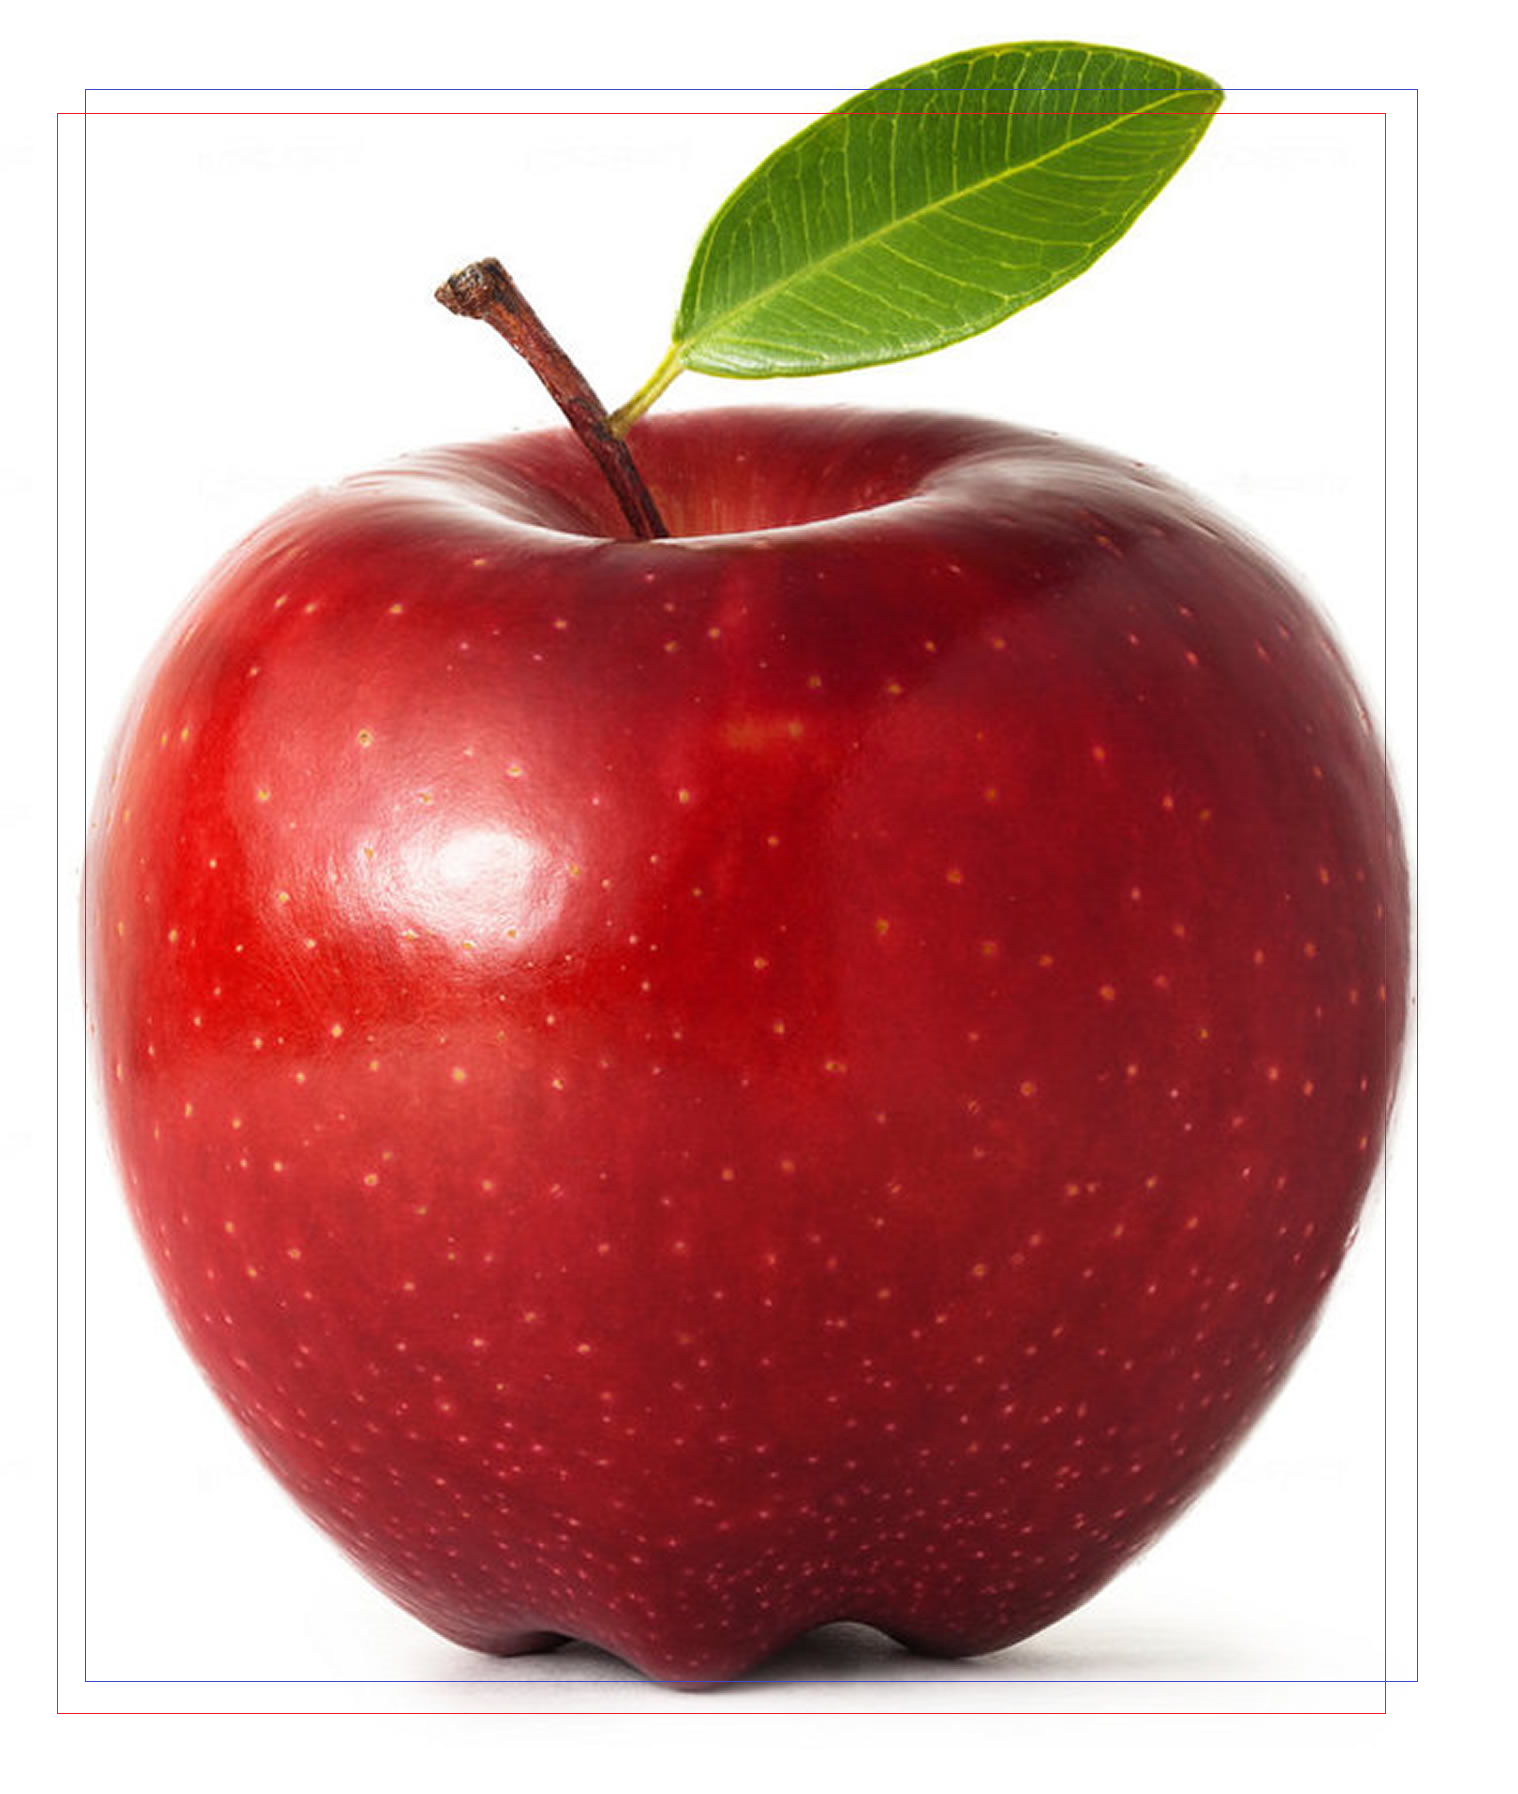

In [12]:
from PIL import ImageDraw

image, labels = next(iter_dataset)
pred = model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline = 'blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


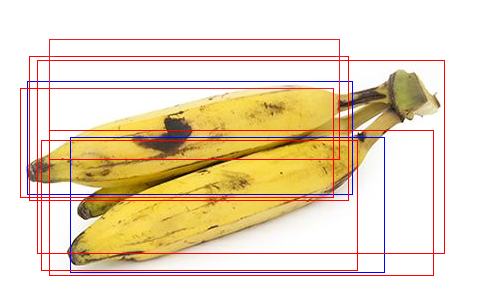

In [13]:
from PIL import ImageDraw

image, labels = next(iter_dataset)
pred = model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline = 'blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Почему-то яблоко огромное вывелось, а банан нормальный. Ну вот так!